In [2]:
import torchvision as tv
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
from pascal_voc_loader import pascalVOCLoader
import umap


Dataset VOCSegmentation
    Number of datapoints: 209
    Root location: ./VOCdata/
(281, 500)
classes in this image are [  0   1  15 255]


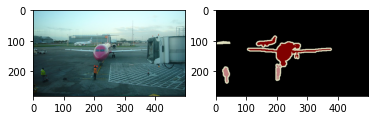

In [3]:

voc_data=tv.datasets.VOCSegmentation('./VOCdata/',
                                     year='2007',
                                     image_set='train', 
                                     download=False)

print(voc_data)

#take a sample image
sample = voc_data[0]
    
plt.figure(1),plt.subplot(121), plt.imshow(sample[0])
plt.subplot(122),plt.imshow(sample[1])

pix = np.array(sample[1])
print(pix.shape)
print("classes in this image are {}".format(np.unique(pix)))


In [4]:
def get_vector(t_img):

    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros((512))
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        x = torch.flatten(o.data, 0)
        my_embedding.copy_(x)
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding


data_loader = pascalVOCLoader(
        "./VOCdata/VOCdevkit/VOC2007/",
        is_transform=True,
        split="train",
        img_size=(224, 224),
    )


# Load the pretrained model
model = models.resnet18(pretrained=True)
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')
model.eval()
use_gpu = False


with torch.no_grad():
    features = []
    feature_masked = []
    y_train = []
    y_train_masked = []

    for batch_idx, (img , target) in enumerate(data_loader):
        if use_gpu:
            img = img.cuda()

        pix = np.array(target)
        nont_zeros = pix[pix>0]
        counts = np.bincount(nont_zeros)
        maj_class = np.argmax(counts)
        #give as input the image as is
        feat_vect = get_vector(img.unsqueeze(0))
        features.append(feat_vect.data.cpu().numpy())
        y_train.append(maj_class)
        
        #mask image with the majority class
        target [target!=maj_class] = 0
        target [target==maj_class] = 1
        img=img*target

        feat_vect = get_vector(img.unsqueeze(0))
        feature_masked.append(feat_vect.data.cpu().numpy())
        y_train_masked.append(maj_class)
        
        


Text(0.5, 1.0, 'Embedding of the training set by UMAP')

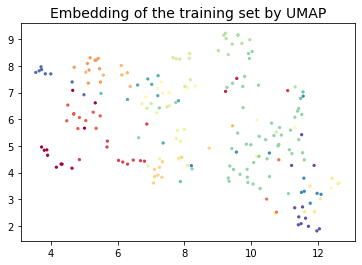

In [21]:
trans = umap.UMAP(n_neighbors=6, min_dist=0.3, random_state=42).fit(features)
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=y_train, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=14)


Text(0.5, 1.0, 'Embedding of the training set by UMAP, masked images')

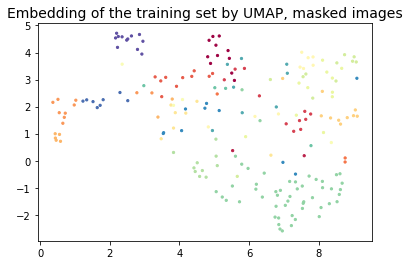

In [20]:
trans = umap.UMAP(n_neighbors=6, min_dist=0.3,random_state=42).fit(feature_masked)
plt.figure()
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=y_train_masked, cmap='Spectral')
plt.title('Embedding of the training set by UMAP, masked images', fontsize=14)